In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno

from analyzer.metric import MetricCalculator
from data.io import Reader, Saver
from data.plot import Drawer
import seaborn as sns
from analyzer.stat_criterion.analyser_timeseries_custom import AnalyserTimeSeriesCustom
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error

# Постановка задачи
Используете параметры времени для включения их в модель SARIMAX

датасет: https://raw.githubusercontent.com/Semendyeav/datasets/refs/heads/main/PDA210_Lecture_1_Enegry_TS.csv


# Выгрузка и проверка целостности датасета

In [188]:
# читаем датасет в память из внешнего источника
df_original = Reader.read_csv("https://raw.githubusercontent.com/Semendyeav/datasets/refs/heads/main/PDA210_Lecture_1_Enegry_TS.csv")
Saver.save_csv(df_original, "PDA210_practice2", False)
df = df_original.copy().reset_index(drop=True)
df.head(10)

Файл успешно сохранён: ./dataset/PDA210_practice2.csv


,date,hour,hourly_demand,hourly_average_price
0,2007-01-19,17,20160000,32.42
1,2002-06-12,5,15087000,28.74
2,2015-04-22,9,15636000,13.24
3,2020-05-23,12,12680000,13.23
4,2022-12-09,8,17655000,60.66
5,2004-12-29,17,19169000,44.55
6,2014-12-22,19,19396000,24.25
7,2022-07-26,24,14688000,43.42
8,2017-08-12,7,13033000,8.43
9,2004-05-15,13,15863000,46.41


In [189]:
# Код для добавления часов к основному времени
def union_time(df):
  return f"{df.date} {(df.hour_23):02d}-00-00"

df['hour_23'] = df['hour']
mask = df['hour_23'] == 24
df.loc[df[mask].index, 'hour_23'] = 0
df['full_date'] = df.apply(union_time, axis = 1)
df['full_date'] = pd.to_datetime(df['full_date'], format = "%Y-%m-%d %H-%M-%S")
df.drop(['hour','date', 'hour_23'], axis=1, inplace=True)

df.head(10)

,hourly_demand,hourly_average_price,full_date
0,20160000,32.42,2007-01-19 17:00:00
1,15087000,28.74,2002-06-12 05:00:00
2,15636000,13.24,2015-04-22 09:00:00
3,12680000,13.23,2020-05-23 12:00:00
4,17655000,60.66,2022-12-09 08:00:00
5,19169000,44.55,2004-12-29 17:00:00
6,19396000,24.25,2014-12-22 19:00:00
7,14688000,43.42,2022-07-26 00:00:00
8,13033000,8.43,2017-08-12 07:00:00
9,15863000,46.41,2004-05-15 13:00:00


In [190]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183432 entries, 0 to 183431
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   hourly_demand         183432 non-null  int64         
 1   hourly_average_price  183432 non-null  float64       
 2   full_date             183432 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 4.2 MB


## пропуски в данных

In [191]:
# посмотрим на пропуски в данных
df.isna().sum()

hourly_demand           0
hourly_average_price    0
full_date               0
dtype: int64

<Axes: >

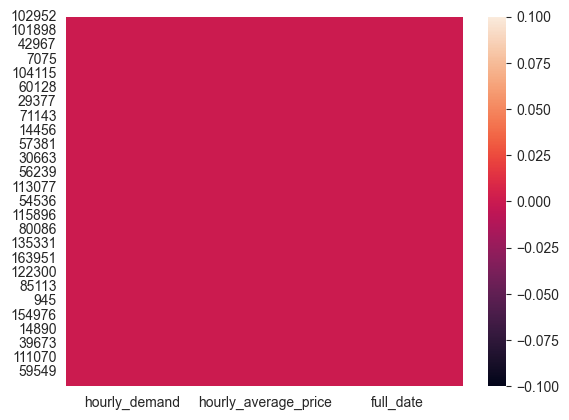

In [192]:
# Посмотрим на пропуски
sns.heatmap(df.sort_values(by='full_date').isna())

<Axes: >

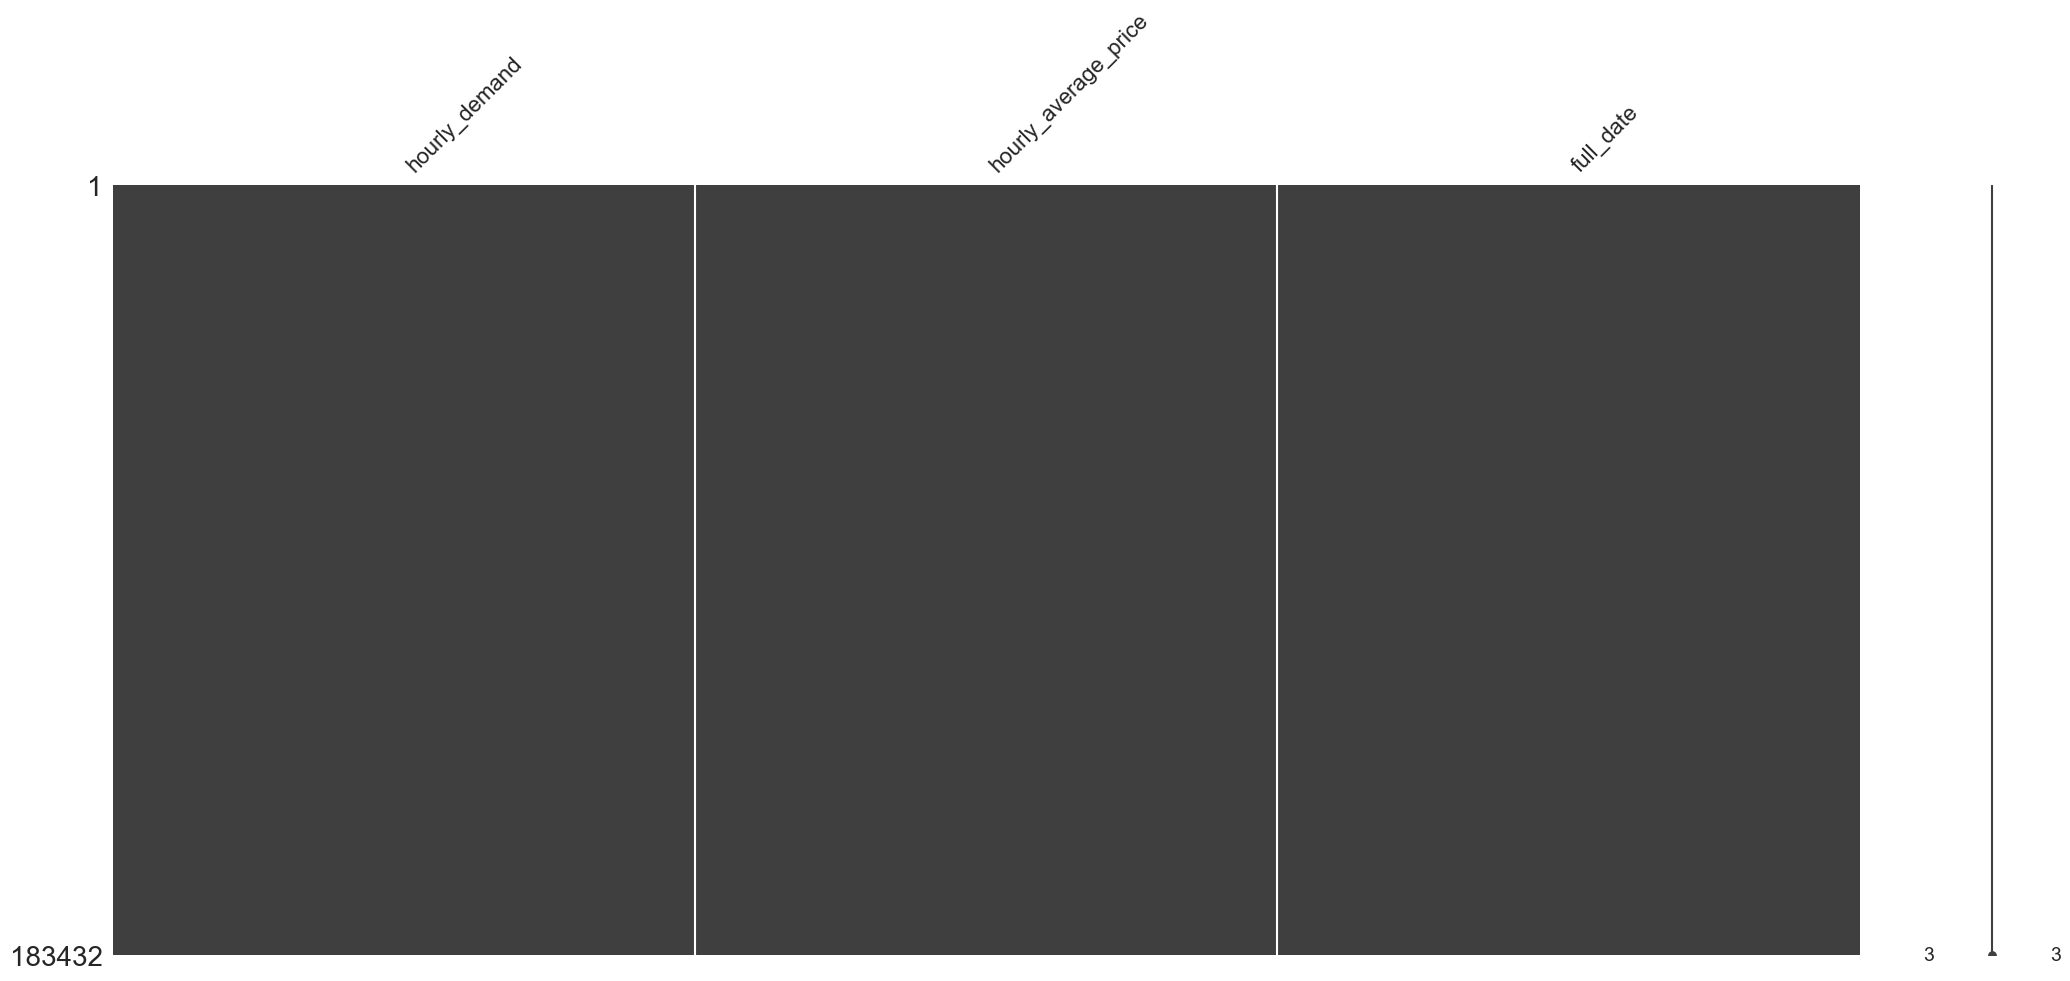

In [193]:
# Посмотрим на пропуски
msno.matrix(df)

## выявление неестественных значений

In [194]:
# Посмотрим статистику о датасете
df.describe()

,hourly_demand,hourly_average_price,full_date
count,1.834320e+05,183432.000000,183432
mean,1.624913e+07,33.812201,2012-10-16 11:30:00
min,2.270000e+06,-138.790000,2002-05-01 00:00:00
25%,1.430700e+07,14.380000,2007-07-24 17:45:00
50%,1.614600e+07,29.755000,2012-10-16 11:30:00
75%,1.803900e+07,43.090000,2018-01-09 05:15:00
max,2.700500e+07,1891.140000,2023-04-03 23:00:00
std,2.592200e+06,33.905004,NaN


In [195]:
mask = df['hourly_average_price'] < 0
df[mask]['hourly_average_price'] 

85        -2.81
124      -31.17
147       -9.58
163       -3.00
168       -0.71
          ...  
183372    -2.81
183379    -3.11
183396    -1.20
183414    -2.74
183419    -0.01
Name: hourly_average_price, Length: 7204, dtype: float64

## реиндексирование временного ряда

In [196]:
df.set_index('full_date', inplace=True)
df = df.sort_index()

In [197]:
df.rename(columns={
    'hourly_demand': 'demand',
    'hourly_average_price': 'average_price'
}, inplace=True)

df['demand'] = df['demand'] / 1E6

In [198]:
df = (
    df
    .resample('W-Mon')
    .sum()
    .fillna(0)
)
period = 52

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1092 entries, 2002-05-06 to 2023-04-03
Freq: W-MON
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   demand         1092 non-null   float64
 1   average_price  1092 non-null   float64
dtypes: float64(2)
memory usage: 25.6 KB


# Первичный визуальный анализ зависимостей в данных

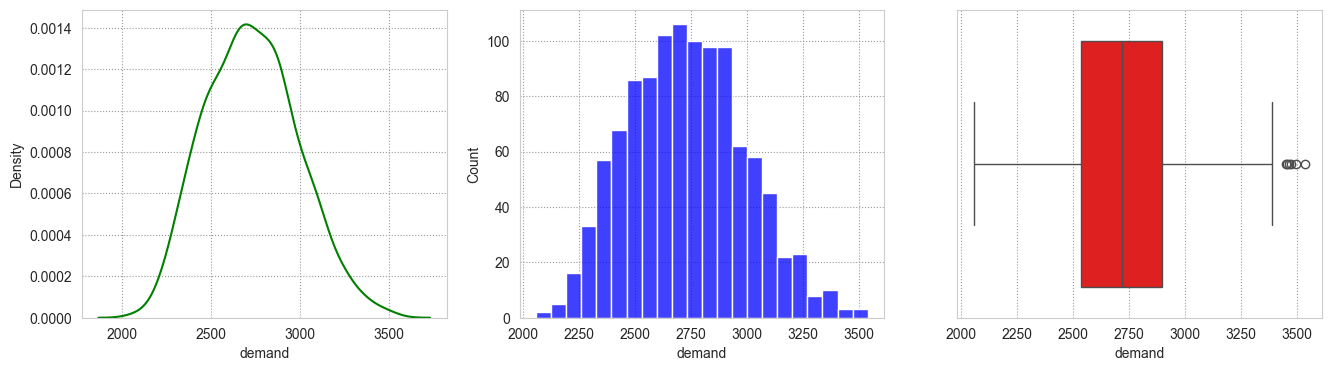

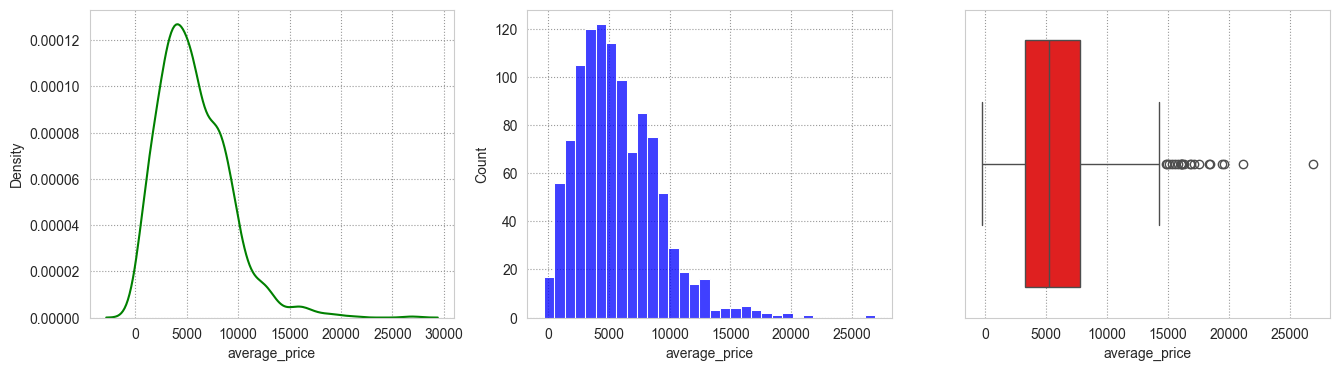

In [199]:
# Посмотрим на виды распределений "числовых" параметров и на ящики с усами
Drawer.plot_numeric_seaborn(df)

In [200]:
# Посмотрим на распределение категориальных величин
Drawer.plot_categorical_seaborn(df)

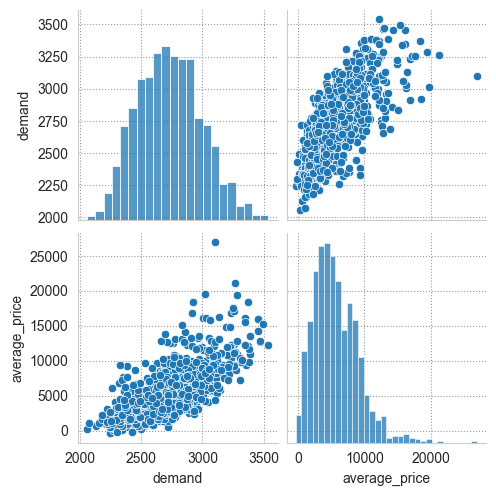

In [201]:
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

# Анализ взаимосвязей в данных

## декомпозиция

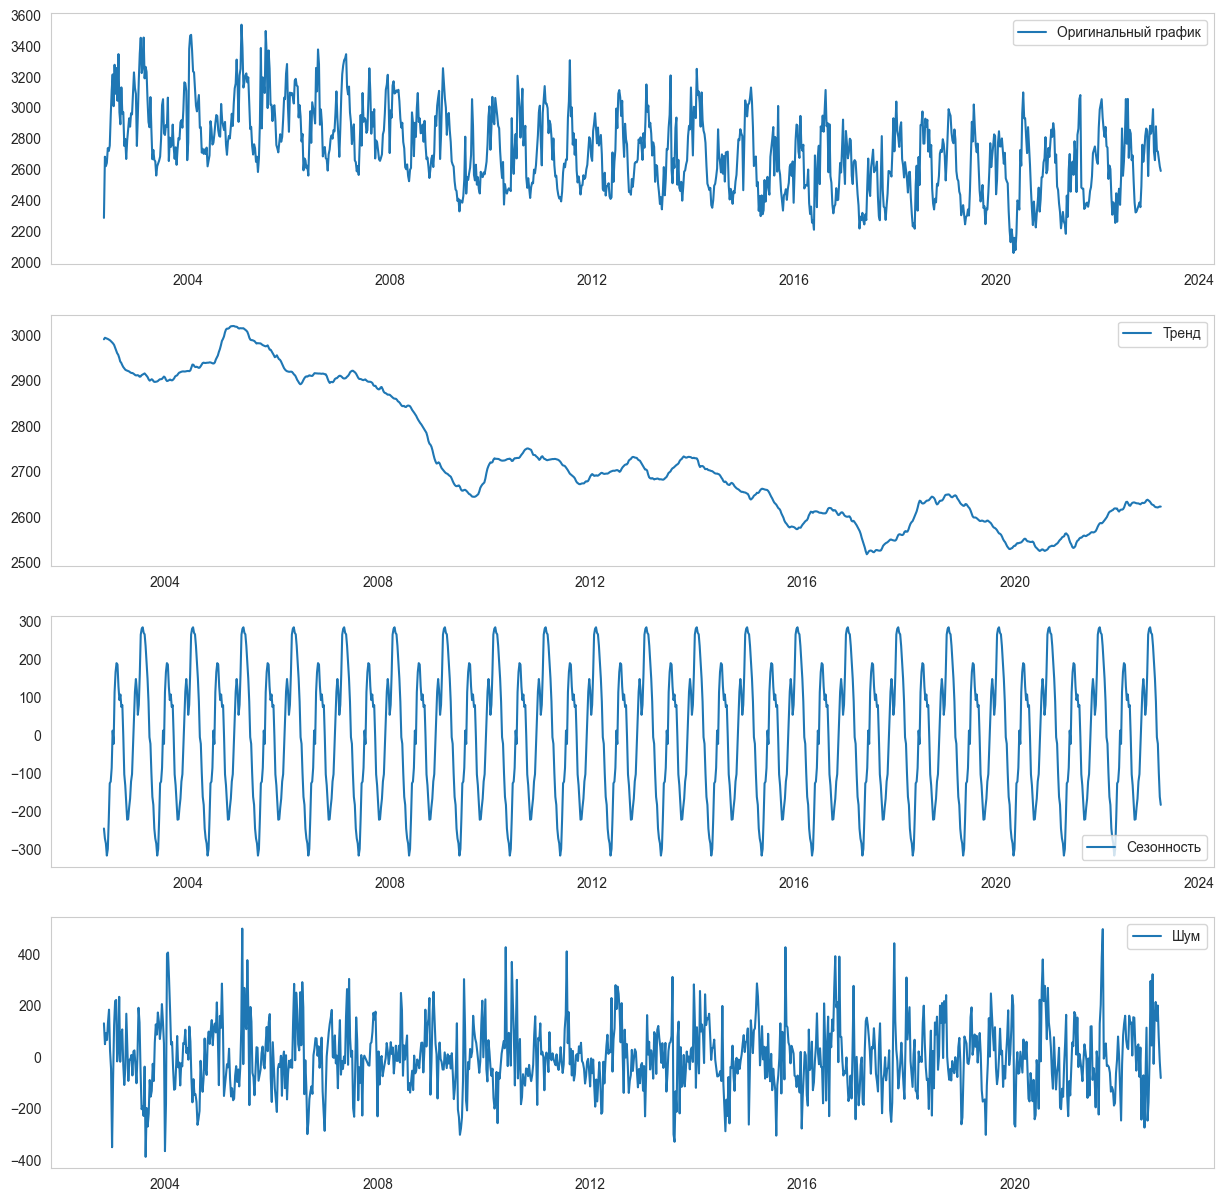

In [202]:
analysis = AnalyserTimeSeriesCustom(df['demand'])
analysis.decompositon(model='add', period=period)

## автокорреляционное разложение

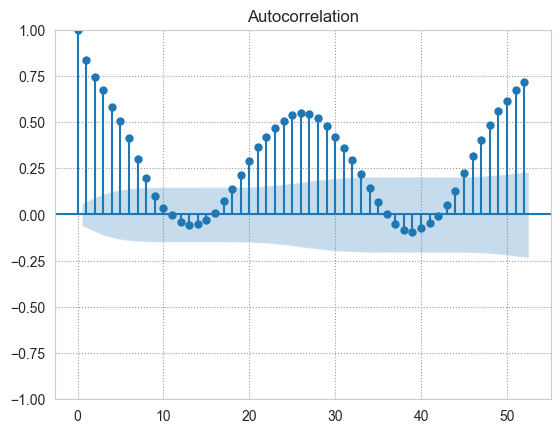

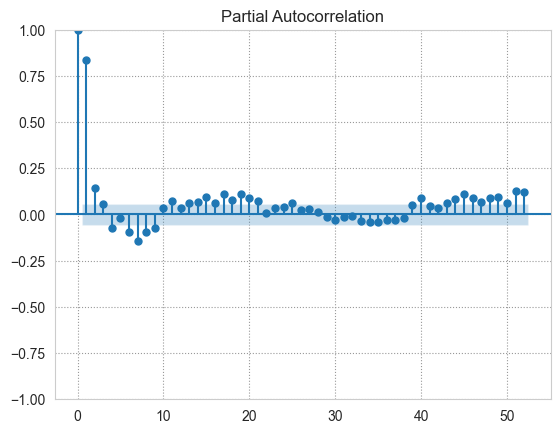

In [203]:
analysis.auto_correlation(period)

## подготовка данных для временного ряда

In [204]:
separate_point = int(len(df) * 0.75)

y_train = df['demand'][:separate_point]
y_test = df['demand'][separate_point:]

X_train = df.drop(columns=['demand'])[:separate_point]
X_test = df.drop(columns=['demand'])[separate_point:]

## модель SARIMAX

In [205]:
model = SARIMAX(
    y_train,
    exog=X_train,
    order=(1,1,1),
    seasonal_order=(1,1,1,period)
)
results = model.fit(disp=False)

prediction = results.get_forecast(
    steps=len(y_test),
    exog=X_test[:len(y_test)] 
)
y_pred = prediction.predicted_mean

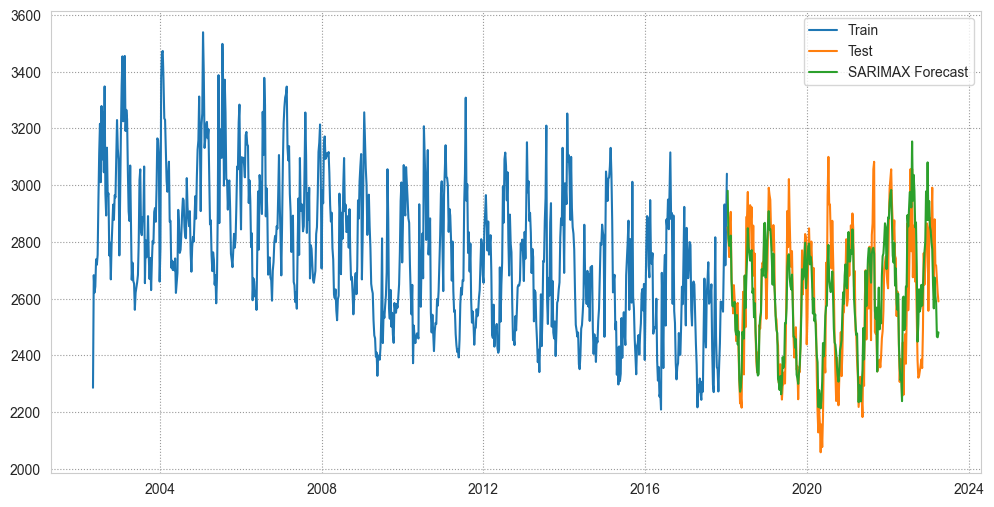

R²: 0.696
MAE: 98.29
MAPE: 0%
RMSE: 126
MSE: 15978


In [206]:
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='SARIMAX Forecast')
plt.legend()
plt.show()

MetricCalculator.show_regression_metrics(y_test, y_pred)

## модель XGB

In [207]:
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

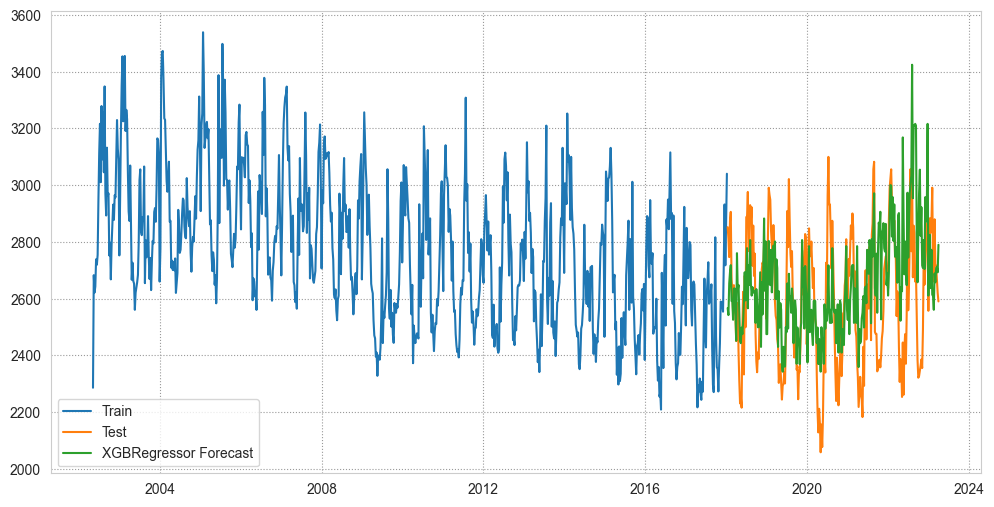

R²: 0.068
MAE: 174.78
MAPE: 0%
RMSE: 221
MSE: 48967


In [209]:
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='XGBRegressor Forecast')
plt.legend()
plt.show()

MetricCalculator.show_regression_metrics(y_test, y_pred)